# Need to execute these cells, start editing at bottom at 'start modifying here'

In [1]:
import sys
sys.path.append('../')
import systemsounds as ss
import numpy as np
import rebound
filename = "../binaries/trappist.bin"
sim = rebound.Simulation.from_file(filename)
sim.t = 0
ss.rescale_time(sim, sim.particles[-1].P)

In [2]:
def OrbitPlotOneSlice(sim, ax, lim=None, limz=None, Narc=100, color=False, periastron=False, trails=False, show_orbit=True, lw=1., axes="xy", plotparticles=[]):
    import matplotlib.pyplot as plt 
    from matplotlib.collections import LineCollection
    from matplotlib.colors import LinearSegmentedColormap
    import numpy as np
    if not plotparticles: # default. No plotparticles list passed, so plot all obits
        orbits = sim.calculate_orbits()
    else: 
        orbits = []
        for p in plotparticles:
            try:
                orbits.append(sim.particles[p].orbit)
            except ParticleNotFound:
                raise AttributeError("Particle in plotparticles list passed to OrbitPlot not found in the simulation.")

    particles = sim.particles
    if lim is None:
        lim = 0.
        for o in orbits:
            if o.a>0.:
                r = (1.+o.e)*o.a
            else:
                r = o.d 
            if r>lim:
                lim = r 
        lim *= 1.15
    if limz is None:
        z = [p.z for p in particles]
        limz = 2.0*max(z)
        if limz > lim:
            limz = lim 
        if limz <= 0.: 
            limz = lim 


    if axes[0]=="z":
        ax.set_xlim([-limz,limz])
    else:
        ax.set_xlim([-lim,lim])
    if axes[1]=="z":
        ax.set_ylim([-limz,limz])
    else:
        ax.set_ylim([-lim,lim])

    if color:
        if color == True:
            colors = [(1.,0.,0.),(0.,0.75,0.75),(0.75,0.,0.75),(0.75, 0.75, 0,),(0., 0., 0.),(0., 0., 1.),(0., 0.5, 0.)]
        if isinstance(color, str):
            colors = [getcolor(color)]
        if isinstance(color, list):
            colors = []
            for c in color:
                colors.append(getcolor(c))
    else:
        colors = [(0.,0.,0.)]

    coloriterator = cycle(colors)

    ax.scatter(getattr(particles[0],axes[0]),getattr(particles[0],axes[1]), marker="*", s=35*lw, facecolor="black", edgecolor=None, zorder=3)
    for i, o in enumerate(orbits):
        colori = next(coloriterator)
        primary = sim.calculate_com(last=i)
        pp = Particle(a=o.a, f=o.f, inc=o.inc, omega=o.omega, Omega=o.Omega, e=o.e, m=particles[i+1].m, primary=primary, simulation=sim)
        ax.scatter(getattr(pp,axes[0]), getattr(pp,axes[1]), s=25*lw, facecolor="black", edgecolor=None, zorder=3)
        if o.a>0.: # bound orbit
            segments = np.zeros((Narc,2,2))
            if show_orbit:
                phase = np.linspace(0,2.*np.pi,Narc)
                for j,ph in enumerate(phase):
                    newp = Particle(a=o.a, f=o.f+ph, inc=o.inc, omega=o.omega, Omega=o.Omega, e=o.e, m=particles[i+1].m, primary=primary, simulation=sim)
                    xy = [getattr(newp,axes[0]), getattr(newp,axes[1])]
                    segments[j][1]=xy
                    segments[(j+1)%Narc][0]=xy
            cdict = {'red': ((0.,colori[0],colori[0]),(1.,colori[0],colori[0])),
                     'green': ((0.,colori[1],colori[1]),(1.,colori[1],colori[1])),
                     'blue': ((0.,colori[2],colori[2]),(1.,colori[2],colori[2]))}
            if trails:
                cdict['alpha'] = ((0.,0.,0.),(1.,1.,1.))
            individual_cm = LinearSegmentedColormap('indv1', cdict)
            lc = LineCollection(segments, cmap=individual_cm, linewidth=lw)
            if show_orbit:
                lc.set_array(phase)
            ax.add_collection(lc)
        else:     # unbound orbit.  Step in M rather than f, since for hyperbolic orbits f stays near lim, and jumps to -f at peri
            t_cross = 4.*o.d/o.v # rough time to cross display box

            lim_phase = abs(o.n)*t_cross # M = nt, n is negative
            segments = np.zeros((Narc,2,2))
            if show_orbit:
                phase = np.linspace(-lim_phase+o.M,o.M,Narc)
                for j,ph in enumerate(phase):
                    newp = Particle(a=o.a, M=ph, inc=o.inc, omega=o.omega, Omega=o.Omega, e=o.e, m=particles[i+1].m, primary=primary, simulation=sim)
                    xy = [getattr(newp,axes[0]), getattr(newp,axes[1])]
                    segments[j][1]=xy
                    if j+1<Narc:
                       segments[j+1][0]=xy
                    if j==0:
                       segments[j][0]=xy
            cdict = {'red': ((0.,colori[0],colori[0]),(1.,colori[0],colori[0])),
                     'green': ((0.,colori[1],colori[1]),(1.,colori[1],colori[1])),
                     'blue': ((0.,colori[2],colori[2]),(1.,colori[2],colori[2]))}
            if trails:
                cdict['alpha'] = ((0.,0.,0.),(1.,1.,1.))
            individual_cm = LinearSegmentedColormap('indv1', cdict)
            lc = LineCollection(segments, cmap=individual_cm, linewidth=lw)
            if show_orbit:
                lc.set_array(phase)
            ax.add_collection(lc)
            
            segments = np.zeros((Narc,2,2))
            if show_orbit:
                phase = np.linspace(o.M,o.M+lim_phase,Narc)
                for j,ph in enumerate(phase):
                    newp = Particle(a=o.a, M=ph, inc=o.inc, omega=o.omega, Omega=o.Omega, e=o.e, m=particles[i+1].m, primary=primary, simulation=sim)
                    xy = [getattr(newp,axes[0]), getattr(newp,axes[1])]
                    segments[j][1]=xy
                    if j+1<Narc:
                       segments[j+1][0]=xy
                    if j==0:
                       segments[j][0]=xy
            cdict = {'red': ((0.,colori[0],colori[0]),(1.,colori[0],colori[0])),
                     'green': ((0.,colori[1],colori[1]),(1.,colori[1],colori[1])),
                     'blue': ((0.,colori[2],colori[2]),(1.,colori[2],colori[2]))}
            if trails:
                cdict['alpha'] = ((0.,0.2,0.2),(1.,0.2,0.2))
            individual_cm = LinearSegmentedColormap('indv1', cdict)
            lc = LineCollection(segments, cmap=individual_cm, linewidth=lw)
            if show_orbit:
                lc.set_array(phase)
            ax.add_collection(lc)


        if periastron:
            newp = Particle(a=o.a, f=0., inc=o.inc, omega=o.omega, Omega=o.Omega, e=o.e, m=particles[i+1].m, primary=primary, simulation=sim)
            ax.plot([getattr(primary,axes[0]), getattr(newp,axes[0])], [getattr(primary,axes[1]), getattr(newp,axes[1])], linestyle="dotted", c=colori, zorder=1, lw=lw)
            ax.scatter([getattr(newp,axes[0])],[getattr(newp,axes[1])], marker="o", s=5.*lw, facecolor="none", edgecolor=colori, zorder=1)


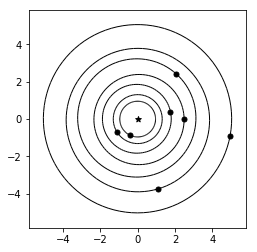

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import cycle
from rebound import Particle
fig, ax = plt.subplots()
OrbitPlotOneSlice(sim, ax)
ax.set_aspect('equal')

In [4]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap    

In [5]:
def get_orbit(particle, Npts=100):
    p = particle
    o = np.zeros((Npts, 3))
    if p.a>0.: # bound orbit
        phase = np.linspace(0,2.*np.pi,Npts)
        for i,ph in enumerate(phase):
            newp = Particle(a=p.a, f=p.f+ph, inc=p.inc, omega=p.omega, Omega=p.Omega, e=p.e, m=p.m, simulation=p._sim.contents)
            o[i][0] = newp.x
            o[i][1] = newp.y
            o[i][2] = newp.z
    else:     # unbound orbit.  Step in M rather than f, since for hyperbolic orbits f stays near lim, and jumps to -f at peri
        t_cross = 4.*p.d/p.v # rough time to cross display box
        lim_phase = abs(p.n)*t_cross # M = nt, n is negative
        
        # do half the points before current position
        firsthalf = Npts // 2
        phase = np.linspace(p.M-lim_phase,p.M,firsthalf,endpoint=False)
        for i,ph in enumerate(phase):
            newp = Particle(a=p.a, M=ph, inc=p.inc, omega=p.omega, Omega=p.Omega, e=p.e, m=p.m, simulation=p._sim.contents)
            o[i][0] = newp.x
            o[i][1] = newp.y
            o[i][2] = newp.z
        
        # do half the points after the current position
        lasthalf = Npts - firsthalf
        phase = np.linspace(p.M,p.M+lim_phase,lasthalf)
        for i,ph in enumerate(phase):
            newp = Particle(a=p.a, M=ph, inc=p.inc, omega=p.omega, Omega=p.Omega, e=p.e, m=p.m, simulation=p._sim.contents)
            o[firsthalf+i][0] = newp.x
            o[firsthalf+i][1] = newp.y
            o[firsthalf+i][2] = newp.z
    return o

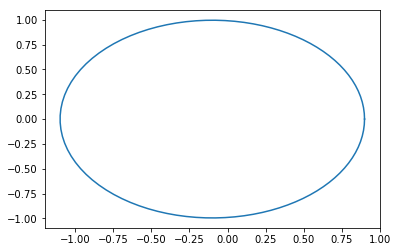

In [6]:
%matplotlib inline
fig, ax = plt.subplots()
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1.,e=0.1)
o = get_orbit(sim.particles[1])
ax.plot(o[:,0], o[:,1])

In [7]:
import matplotlib.colors as mplcolors
    
def getcolor(color):
    try:
        hexcolor = mplcolors.cnames[color]
    except KeyError:
        raise AttributeError("Color passed to OrbitPlot not recognized in matplotlib.")

    hexcolor = hexcolor.lstrip('#')
    lv = len(hexcolor)
    return tuple(int(hexcolor[i:i + lv // 3], 16)/255. for i in range(0, lv, lv // 3)) # tuple of rgb values

In [8]:
def get_orbit_trail(orbitcoordinates, color='black', hyperbolic=False, lw=1.):
    color = getcolor(color)
    o = orbitcoordinates
    Npts = len(o)
    # cdict with opacity going from 0 to 1 in trail
    cdict = {'red': ((0.,color[0],color[0]),(1.,color[0],color[0])),
             'green': ((0.,color[1],color[1]),(1.,color[1],color[1])),
             'blue': ((0.,color[2],color[2]),(1.,color[2],color[2])),
             'alpha': ((0.,0.,0.),(1.,1.,1.))}
    # cdict with opacity constant at 0.2 for points ahead of hyperbolic orbit
    cdict2 = {'red': ((0.,color[0],color[0]),(1.,color[0],color[0])),
             'green': ((0.,color[1],color[1]),(1.,color[1],color[1])),
             'blue': ((0.,color[2],color[2]),(1.,color[2],color[2])),
             'alpha': ((0.,0.2,0.2),(1.,0.2,0.2))}
    
    if hyperbolic is True:
        firsthalf = Npts // 2
        segments = np.zeros((firsthalf,2,2))
        
        for i in range(firsthalf):
            xy = [o[i][0], o[i][1]]
            segments[i][1]=xy
            if i+1<firsthalf:
               segments[i+1][0]=xy
            if i==0:
               segments[i][0]=xy
        individual_cm = LinearSegmentedColormap('indv1', cdict)
        lc1 = LineCollection(segments, cmap=individual_cm, linewidth=lw)
        lc1.set_array(np.linspace(0.,0.5,firsthalf))
        
        lasthalf = Npts - firsthalf
        segments = np.zeros((lasthalf,2,2))
        for i in range(lasthalf):
            xy = [o[firsthalf+i][0], o[firsthalf+i][1]]
            segments[i][1]=xy
            if i+1<lasthalf:
               segments[i+1][0]=xy
            if i==0:
               segments[i][0]=xy
        
        #cdict['alpha'] = ((0.,0.2,0.2),(1.,0.2,0.2))
        individual_cm = LinearSegmentedColormap('indv1', cdict)
        lc2 = LineCollection(segments, cmap=individual_cm, linewidth=lw)
        lc2.set_array(np.linspace(0.5,1.,lasthalf))
        return [lc1, lc2]
    else:
        segments = np.zeros((Npts-1,2,2))
        for i in range(Npts-1):
            xy = [o[i][0], o[i][1]]
            segments[i][1] = xy
            segments[(i+1)%(Npts-1)][0] = xy
        individual_cm = LinearSegmentedColormap('indv1', cdict)
        lc = LineCollection(segments, cmap=individual_cm, linewidth=lw)
        lc.set_array(np.linspace(0.,1.,Npts))
    return lc

(-1, 1)

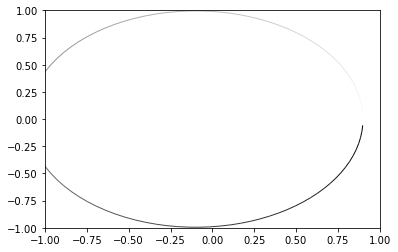

In [9]:
%matplotlib inline
fig, ax = plt.subplots()
lc = get_orbit_trail(o)
ax.add_collection(lc)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

# Start Modifying Here

In [13]:
import sys
sys.path.append('../')
import systemsounds as ss
import numpy as np
import rebound
filename = "../binaries/trappist.bin"
sim = rebound.Simulation.from_file(filename)
sim.t = 0
ss.rescale_time(sim, sim.particles[-1].P)

# First integrate backwards for the length of the integration we want to do, so that when we go forwards we end up at time 0 to match up with movie

In [14]:
sim.integrate(-2)

# This is a hack to get around the fact that the current code does not handle negative times correctly

In [15]:
sim.t = 0

# This makes theta vary from inclined to face on over the integration. Can do a fixed inclination with a single frames.theta = 60.*np.pi/180

In [16]:
frames = ss.FrameRecorder(sim, time_per_sec=0.5)
frames.color = ['red','darkorange','forestgreen','cyan','deepskyblue','violet','darkviolet']

Nout = 20
times = np.linspace(0, 2, Nout)
thetas = np.linspace(60.*np.pi/180., 0, Nout)

for i, time in enumerate(times):
    frames.theta = thetas[i]
    sim.integrate(time) # integrate for two outer planet orbits

# Helper functions for rotations. Set up to just do a simple rotation around the x axis by theta. Let me know if you want me to generalize this

In [19]:
def rotate_particles(sim, theta):
    xyz = np.zeros((sim.N, 3))
    for i, p in enumerate(sim.particles):
        xyz[i][0] = p.x
        xyz[i][1] = p.y
        xyz[i][2] = p.z
    rotmatrix = np.array([[1,0,0], [0,np.cos(theta),-np.sin(theta)], [0,np.sin(theta),np.cos(theta)]])
    return rotmatrix.dot(xyz.T).T

def rotate_orbit(o, theta):
    rotmatrix = np.array([[1,0,0], [0,np.cos(theta),-np.sin(theta)], [0,np.sin(theta),np.cos(theta)]])
    return rotmatrix.dot(o.T).T

# I've tried to comment below what each section of code does so it's hopefully easy to edit

In [20]:
import matplotlib.pyplot as plt

def write_png(params):
    fig, ax = plt.subplots(figsize=(8,8))
    fig.axes[0].axis('off') # turn off axes
    colors = params['color']                       # colors for each of the particles (including the star)
    theta=params['theta']
    lw=1. # line width
    
    sim = rebound.Simulation.from_file(params['filename'])
    ps = sim.particles
    
    # set plot boundaries to larger than outermost planet
    lim = 1.15*ps[-1].a
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    
    # get rotated xyz coordinates for all bodies
    xyz = rotate_particles(sim, theta)
    # plot star
    ax.scatter(xyz[0][0], xyz[0][1], marker="*", s=35*lw, facecolor="black", edgecolor=None, zorder=3)
    
    for i, p in enumerate(sim.particles[1:]):
        # plot planet
        ax.scatter(xyz[i+1][0], xyz[i+1][1], s=25*lw, facecolor=colors[i], edgecolor=None, zorder=3)
        #plot orbit
        o = get_orbit(p)
        o = rotate_orbit(o, theta)
        lc = get_orbit_trail(o, color=colors[i], lw=lw)
        ax.add_collection(lc)
        
    fig.savefig('tmp/pngs/{0:0=5d}.png'.format(params['frame_ctr']))
    plt.close(fig)

We now write all the frames using our function. Making matplotlib plots is not optimized for efficiency, so it's quite slow. We therefore generate them in parallel.

In [21]:
%%time
from subprocess import call
call("rm -f tmp/pngs/*", shell=True)
pool = rebound.InterruptiblePool()
res = pool.map(write_png, frames.events)

CPU times: user 24.7 ms, sys: 29.2 ms, total: 53.9 ms
Wall time: 7.95 s


# Outputting a movie file

You now have all the frames for the movie in `systemsounds/jupyter_examples/tmp/pngs`, and can stitch them together into a movie using your favorite software. For some ideas and options, see [MovieEditingSoftware.ipynb](MovieEditingSoftware.ipynb)

# More advanced example

Everyone will want to do something slightly differently, so rather than building up a complicated framework with many options, the idea is that people can contribute examples to this repository that others can draw on to make their own custom movies. We're looking forward to seeing what people come up with! For a more complicated example see [TRAPPIST1.ipynb](TRAPPIST1.ipynb)